# Wavelet-style patch model

The code below produces and trains a flexible image model which, in this context, is used for image-to-image translation between microscope types. It is still a work in progress.

In [ ]:
## Load libraries
from tqdm import tqdm
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The model hinges on operations that break an image into square patches and assemble patches into an image. The central idea for the model to which these functions contribute is to divide a large image into small patches and to sort the signal in each patch into a component that is local and a component that is non-local. The non-local components from each patch get stitched together, creating a new image for the model to work on. This is not dissimilar from the action of a Unet (convolutional neural network).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def image_to_patches(image_tensor, patch_size):
    """
    Convert an image tensor to a tensor of patches.

    Args:
        image_tensor: A tensor of shape (C, H, W) or (B, C, H, W)
        patch_size: Int or tuple (height, width) for patch dimensions

    Returns:
        A tensor of patches with shape (B, N, C, P_h, P_w) where:
        - B is the batch size (1 if input has no batch dimension)
        - N is the number of patches (depends on image and patch size)
        - C is the number of channels
        - P_h, P_w are the patch dimensions
    """
    # Add batch dimension if not present
    if len(image_tensor.shape) == 3:
        image_tensor = image_tensor.unsqueeze(0)  # (1, C, H, W)

    B, C, H, W = image_tensor.shape

    # Convert to (patch_size, patch_size) tuple if needed
    if isinstance(patch_size, int):
        patch_size = (patch_size, patch_size)

    P_h, P_w = patch_size

    # Calculate number of patches in each dimension
    n_h = H // P_h
    n_w = W // P_w

    # Reshape tensor to extract patches
    patches = image_tensor.unfold(2, P_h, P_h).unfold(3, P_w, P_w)  # (B, C, n_h, n_w, P_h, P_w)

    # Reshape to (B, n_h*n_w, C, P_h, P_w)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches = patches.view(B, n_h * n_w, C, P_h, P_w)

    return patches

def patches_to_image(patches, output_size=None):
    """
    Convert a tensor of patches back to the original image tensor.

    Args:
        patches: A tensor of shape (B, N, C, P_h, P_w) where:
            - B is the batch size
            - N is the number of patches
            - C is the number of channels
            - P_h, P_w are the patch dimensions
        output_size: Optional tuple (H, W) specifying the output image size.
                     If None, will compute based on patches assuming equal spacing.

    Returns:
        A tensor of shape (B, C, H, W) with the reconstructed image
    """
    B, N, C, P_h, P_w = patches.shape

    # Calculate grid dimensions (assuming square grid for simplicity)
    n = int(N**0.5)

    # Verify we have a perfect square number of patches
    if n*n != N:
        raise ValueError(f"Number of patches {N} is not a perfect square. Cannot determine grid layout.")

    # Calculate original image dimensions
    if output_size is None:
        H, W = n * P_h, n * P_w
    else:
        H, W = output_size

    # Reshape patches to form a grid
    patches = patches.view(B, n, n, C, P_h, P_w)

    # Permute and reshape to prepare for folding
    patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
    patches = patches.view(B, C, n * P_h, n * P_w)

    # Return the reconstructed image
    return patches

# Image-to-image

In the code below I load some image data from a private google drive. This will obviously not work for people without access.

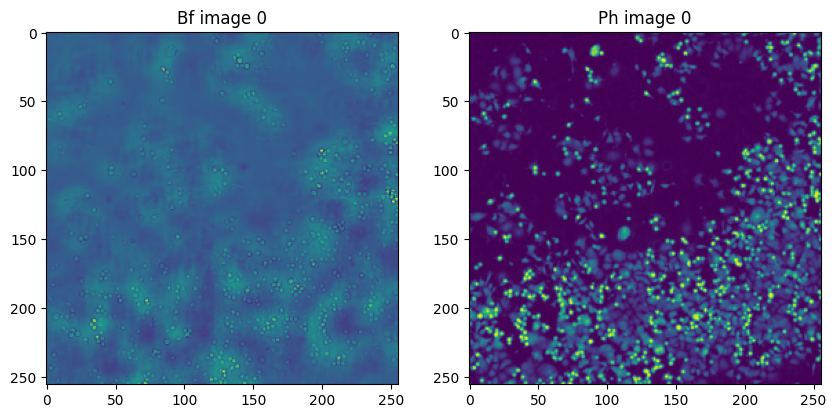

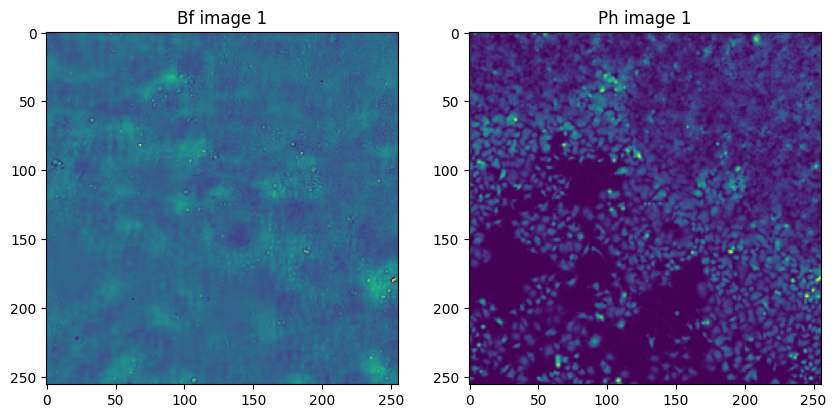

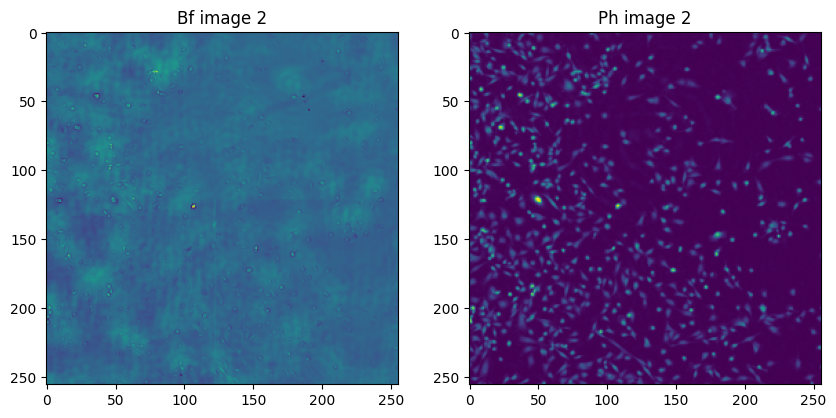

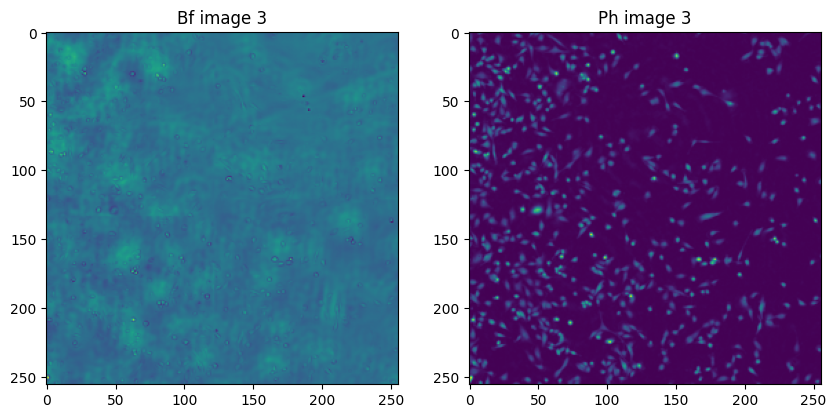

In [ ]:
preamble = '/content/drive/Shareddrives/CellPhe 2 - Permanent Data Storage/Preprocessed_images/'
batch_names = [preamble+'bf_ph_batch_0.npz',preamble+'bf_ph_batch_1.npz',preamble+'bf_ph_batch_2.npz',preamble+'bf_ph_batch_3.npz']
# batch_names = [preamble+'bf_ph_batch_4.npz',preamble+'bf_ph_batch_5.npz',preamble+'bf_ph_batch_6.npz',preamble+'bf_ph_batch_7.npz']

## Decompress batch file and plot first few image pairs
batch_tensor = torch.empty((0,2,256,256))

for batch_name in batch_names:
  batch = np.load(batch_name)
  batch_array = pickle.loads(batch[batch.files[0]])
  new_batch_tensor = torch.from_numpy(batch_array)
  batch_tensor = torch.cat((batch_tensor[:,:,:,:],new_batch_tensor[:,:,:,:]),dim=0)

batch_tensor[:,0,:,:] = batch_tensor[:,0,:,:] - torch.mean(batch_tensor[:,0,:,:])
batch_tensor[:,0,:,:] = batch_tensor[:,0,:,:] / torch.std(batch_tensor[:,0,:,:])
batch_tensor[:,1,:,:] = batch_tensor[:,1,:,:] - torch.mean(batch_tensor[:,1,:,:])
batch_tensor[:,1,:,:] = batch_tensor[:,1,:,:] / torch.std(batch_tensor[:,1,:,:])

for i in range(4):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(batch_array[i,0,:,:])
  axes[0].set_title('Bf image ' + str(i))
  axes[1].imshow(batch_array[i,1,:,:])
  axes[1].set_title('Ph image ' + str(i))
  plt.show()

The model and its helper functions are defined in the code below. I define my own pair of activation functions, which are inverses of each other, and a 'feedforward' layer. I also define encoder and decoder functions that perform the iterative patch-and-reduce operations interleaved with the feedforward layers.

In [ ]:
def act(x,type=0):
  if type==0:
    out = ((1+2*torch.abs(x))**.5 - 1) * torch.sign(x)
    log_deriv = -torch.sum(torch.log(1 + torch.abs(x)))
  if type==1:
    out = x + x**2 * torch.sign(x) / 2
    log_deriv = torch.sum(torch.log(1 + torch.abs(x)))
  return out, log_deriv

class blayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.A0 = nn.Parameter(torch.eye(8) + 1e-4*torch.randn(8, 8))
        self.A1 = nn.Parameter(torch.eye(8) + 1e-4*torch.randn(8, 8))
        self.B0 = nn.Parameter(1e-4*torch.randn(8, 8))
        self.B1 = nn.Parameter(1e-4*torch.randn(8, 8))

    def forward(self, x):
        log_deriv_tot = 0
        x, log_deriv = act(x,type=0)
        log_deriv_tot += log_deriv
        x = x - (self.B0.unsqueeze(0) + self.B0.T.unsqueeze(0))
        x = torch.einsum('abcde,du->abcue', x, self.A0)
        x = torch.einsum('abcde,eu->abcdu', x, self.A0)
        x, log_deriv = act(x,type=1)
        log_deriv_tot += log_deriv
        x = x - (self.B1.unsqueeze(0) + self.B1.T.unsqueeze(0))
        x = torch.einsum('abcde,du->abcue', x, self.A1)
        x = torch.einsum('abcde,eu->abcdu', x, self.A1)
        return(x, log_deriv_tot)

class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_layer0 = blayer()
        self.enc_layer1 = blayer()
        self.enc_layer2 = blayer()
        self.enc_layer3 = blayer()
        self.enc_layer4 = blayer()
        self.enc_layer5 = blayer()
        self.enc_list = [self.enc_layer0, self.enc_layer1, self.enc_layer2, self.enc_layer3, self.enc_layer4, self.enc_layer5]

    def forward(self, x, depth=0):
        x = image_to_patches(x, patch_size=8)
        x, log_deriv = self.enc_list[depth](x)
        if x.shape[1]<2:
          return patches_to_image(x)
        x11 = self.forward(patches_to_image(x[:,:,:,0:4,0:4]),depth+1)
        x12 = patches_to_image(x[:,:,:,0:4,4:8])
        x21 = patches_to_image(x[:,:,:,4:8,0:4])
        x22 = patches_to_image(x[:,:,:,4:8,4:8])
        x1 = torch.cat((x11,x12),dim=3)
        x2 = torch.cat((x21,x22),dim=3)
        x = torch.cat((x1,x2),dim=2)
        return x

class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dec_layer0 = blayer()
        self.dec_layer1 = blayer()
        self.dec_layer2 = blayer()
        self.dec_layer3 = blayer()
        self.dec_layer4 = blayer()
        self.dec_layer5 = blayer()
        self.dec_list = [self.dec_layer0, self.dec_layer1, self.dec_layer2, self.dec_layer3, self.dec_layer4, self.dec_layer5]

    def forward(self, x, depth=5):
        if x.shape[2]==4:
          return x
        else:
          ind1 = x.shape[2]//2
          ind2 = x.shape[2]
          x11 = image_to_patches(self.forward(x[:,:,0:ind1,0:ind1],depth-1), patch_size=4)
          x12 = image_to_patches(x[:,:,0:ind1,ind1:ind2], patch_size=4)
          x21 = image_to_patches(x[:,:,ind1:ind2,0:ind1], patch_size=4)
          x22 = image_to_patches(x[:,:,ind1:ind2,ind1:ind2], patch_size=4)
          x = torch.cat((torch.cat((x11,x12),dim=4),torch.cat((x21,x22),dim=4)),dim=3)
          x, log_deriv = self.dec_list[depth](x)
          x = patches_to_image(x)
          return x

Instantiate the encoder and decoder models and load some previously fitted parameters.

In [ ]:
bencoder = encoder()
bdecoder = decoder()

bencoder.load_state_dict(torch.load('/content/drive/MyDrive/bencoder_2025-04-06 21:08:36.pth'))
bdecoder.load_state_dict(torch.load('/content/drive/MyDrive/bdecoder_2025-04-06 21:08:36.pth'))

<All keys matched successfully>

The code below is used for adjusting the model parameters. I use a GPU if there is one available. It appears that the GPU leads to a speed-up of >100x.

In [ ]:
optimizer1 = torch.optim.Adam(bencoder.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(bdecoder.parameters(), lr=1e-3)

In [ ]:
torch.cuda.empty_cache()
if torch.cuda.is_available():
       device = torch.device("cuda")
       bencoder.to(device)
       bdecoder.to(device)
       batch_tensor = batch_tensor.to(device)

In [ ]:
for epoch in tqdm(range(512)):
  optimizer1.zero_grad()
  optimizer2.zero_grad()
  loss = torch.abs(batch_tensor[:,1:2,:,:]-bdecoder(bencoder(batch_tensor[:,0:1,:,:])))
  loss = torch.mean(loss)
  loss.backward(retain_graph=True)
  optimizer1.step()
  optimizer2.step()
  if epoch % 32 == 0:
    print(loss)

  0%|          | 2/512 [00:00<02:07,  4.01it/s]

tensor(0.5227, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 34/512 [00:10<02:30,  3.18it/s]

tensor(0.4295, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 66/512 [00:21<02:20,  3.18it/s]

tensor(0.4149, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 98/512 [00:31<02:09,  3.20it/s]

tensor(0.4117, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 130/512 [00:42<01:59,  3.19it/s]

tensor(0.4065, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 162/512 [00:52<01:49,  3.20it/s]

tensor(0.4045, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 194/512 [01:02<01:39,  3.21it/s]

tensor(0.4025, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 226/512 [01:13<01:29,  3.20it/s]

tensor(0.4018, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 258/512 [01:23<01:19,  3.19it/s]

tensor(0.4004, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 290/512 [01:33<01:09,  3.19it/s]

tensor(0.3997, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 322/512 [01:44<00:59,  3.20it/s]

tensor(0.3990, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 353/512 [01:54<00:57,  2.76it/s]

tensor(0.3984, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 385/512 [02:04<00:45,  2.76it/s]

tensor(0.3980, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 418/512 [02:15<00:29,  3.20it/s]

tensor(0.3975, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 450/512 [02:25<00:19,  3.20it/s]

tensor(0.3970, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 482/512 [02:36<00:09,  3.19it/s]

tensor(0.3967, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 512/512 [02:45<00:00,  3.09it/s]


In [ ]:
torch.save(bencoder.state_dict(), '/content/drive/MyDrive/bencoder_'+datetime.now().strftime("%Y-%m-%d %H:%M:%S")+'.pth')
torch.save(bdecoder.state_dict(), '/content/drive/MyDrive/bdecoder_'+datetime.now().strftime("%Y-%m-%d %H:%M:%S")+'.pth')

We now take a look at the input-, predicted- and target-images.

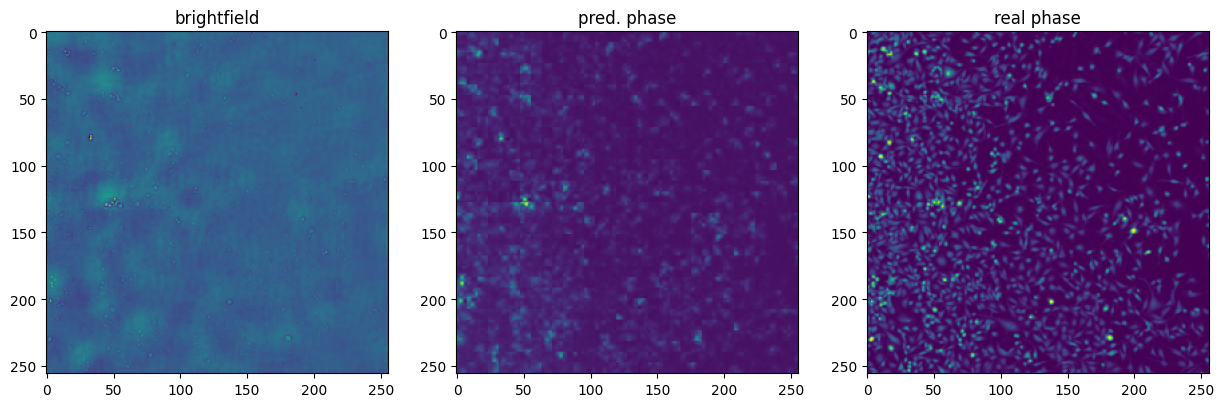

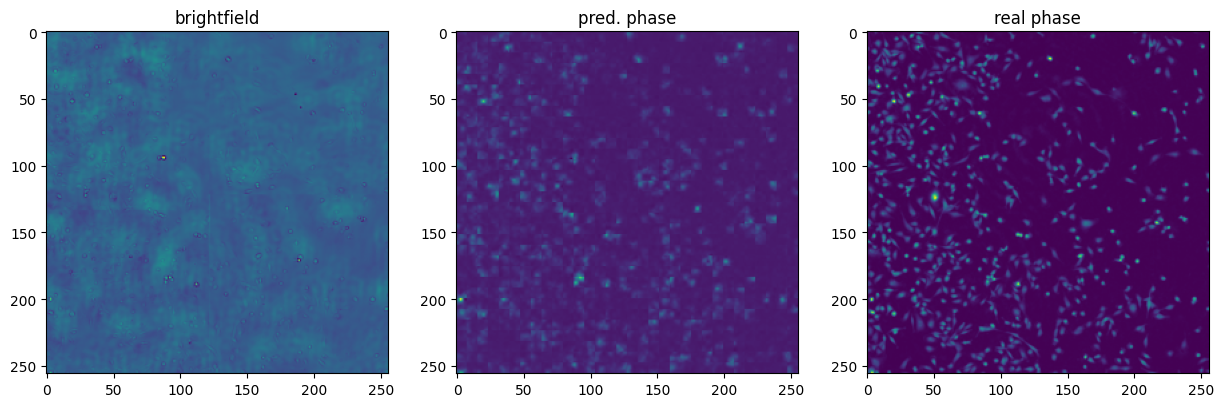

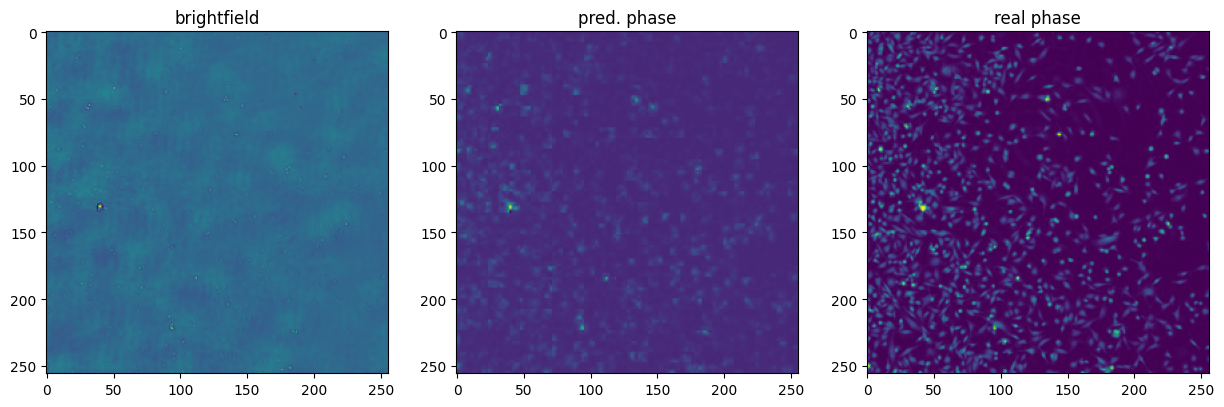

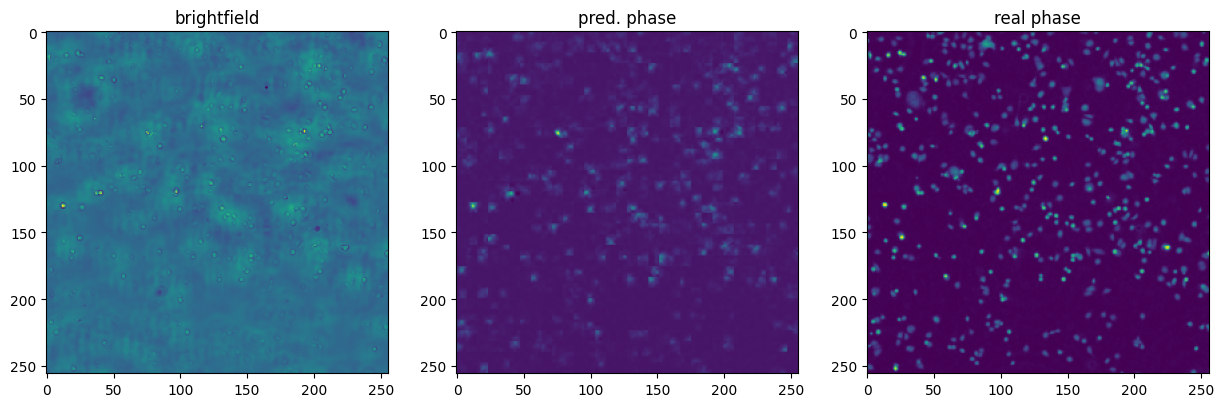

In [ ]:
bencoder.to('cpu')
bdecoder.to('cpu')
x1 = batch_tensor[0:4,0:1,:,:].to('cpu')
x2 = bdecoder(bencoder(x1))
x3 = batch_tensor[0:4,1:2,:,:].to('cpu')

for i in range(4):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  axes[0].imshow(x1.detach().numpy()[i,0,:,:])
  axes[0].set_title('brightfield')
  axes[1].imshow(x2.detach().numpy()[i,0,:,:])
  axes[1].set_title('pred. phase')
  axes[2].imshow(x3.detach().numpy()[i,0,:,:])
  axes[2].set_title('real phase')
  plt.show()